> ## Rover Project: Search and Sample Return 
>> **Project 1 Submission for:** Udacity's Robotics Software Engineer Nanodegree   
>> **Date:** May 28, 2018    
>> **By:** Paul Griz

---


**Run the cell below for markdown code highlighting:**

In [3]:
%%HTML
<style> code {background-color : '#ABB2B9';} </style>

In [4]:
%matplotlib inline
# %matplotlib qt # Choose %matplotlib qt to plot to an interactive window 
    # (note it may show up behind your browser)

import cv2 # OpenCV for the perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving needed images
import glob  # For reading in a list of saved images
import imageio
imageio.plugins.ffmpeg.download()


## Example Data:

The example data is located within the `test_dataset` folder.  

(160, 320, 3)


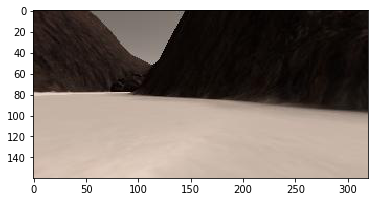

In [5]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
print(image.shape)
plt.imshow(image)

## Calibration Data

The sample grid and rock calibration images within the ``calibration_images`` directory were used to:
- Find proper ``source`` & ``destination`` values for the ``perspective_transform()`` function.
- Get the RGB values required for detecting Rocks.  


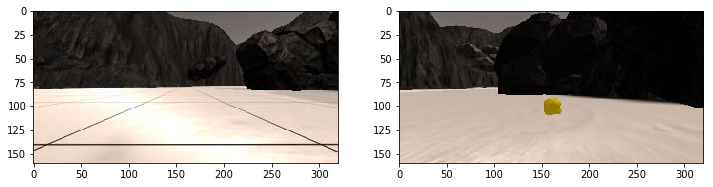

In [6]:
# Here's an example of the grid and a rock
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform Function

The perspective transform function is required in mapping out the environment.   

To preform the transform, the calibration grid example images above were used to get the    
``source`` and ``destination`` points are defined to warp the image to a "top-down" perspective.

**Note:**
- Each grid of 10x10 pixels represents 1 square meter.
- The destination box will be [2 * ``dst_size``] on each side

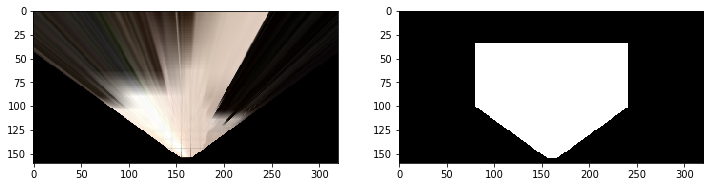

In [7]:
def perspective_transform(img, src, dst):
    """Performs a perspective transform.
    Used to convert the Rover camera's POV to a "top-down" world view."""

    # Get transform matrix using cv2.getPerspectiveTransform()
    transform_matrix = cv2.getPerspectiveTransform(src, dst)

    # Warp image using cv2.warpPerspective()
    # Note: warped image has the same size as input image
    warped = cv2.warpPerspective(
        img, transform_matrix, (img.shape[1], img.shape[0]))

    # Added Mask to only process data from the rover's POV
    # [Removes data NOT in Rover's POV]
    mask = cv2.warpPerspective(src=np.ones_like(img[:, :, 0]), M=transform_matrix,
                               dsize=(img.shape[1], img.shape[0]),
                               borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    # Cropped the mask to narrow the Rover's POV. Improves Rover's navigation.
    mask = mask[35:160, 80:240]
    # Adding a black border to cropped mask to regain original shape of (160, 320)
    mask = cv2.copyMakeBorder(
        mask, 35, 0, 80, 80, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    return warped, mask


# Define calibration box in source (actual) and destination (desired) coordinates
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped, mask = perspective_transform(grid_img, source, destination)

fig = plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.imshow(warped)
plt.subplot(122)
plt.imshow(mask, cmap='gray')

## Color Thresholding Function


The ``color_thresh()`` function receives two parameters:
1. An image
1. A list of 3 RGB values

A boolean expression is applied to all pixels from the input image   
to check filter pixels over or under the input threshold.  

The resulting array of boolean values are then converted to binary values   
and returned by the function.

Used to detect navigable terrain, obstacles, and rock samples. 

---

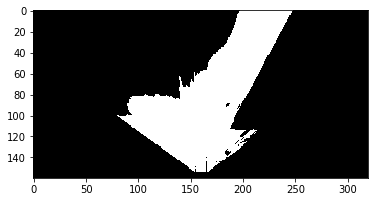

In [8]:
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    """Identifies all pixels above the input RGB threshold.
    A Threshold of RGB > 160 is used to identify the ground pixels."""

    # Select all values from the RGB Red channel from the input img
    # Create a zero array with the same dementions as the Red channel
    color_select = np.zeros_like(img[:, :, 0])

    # Assign True to each pixel above input threshold values in RGB
    # Assign False to all pixels below the threshold
    above_thresh = (img[:, :, 0] > rgb_thresh[0]) \
        & (img[:, :, 1] > rgb_thresh[1]) \
        & (img[:, :, 2] > rgb_thresh[2])

    # Assign 1 to all True values in above_thresh
    color_select[above_thresh] = 1
    
    # Return the binary image
    return color_select


threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

---

![img](https://d17h27t6h515a5.cloudfront.net/topher/2017/May/5921f4f6_screen-shot-2017-05-21-at-1.12.06-pm/screen-shot-2017-05-21-at-1.12.06-pm.png)

## Coordinate Transformations

Defining a fixed coordinate system with respect to the Rover is central to this project.   
Having this coordinate system allows the Rover to find the position of objects within the environment with respect to the Rover.

---

The Functions below are all used to accomplish this task.

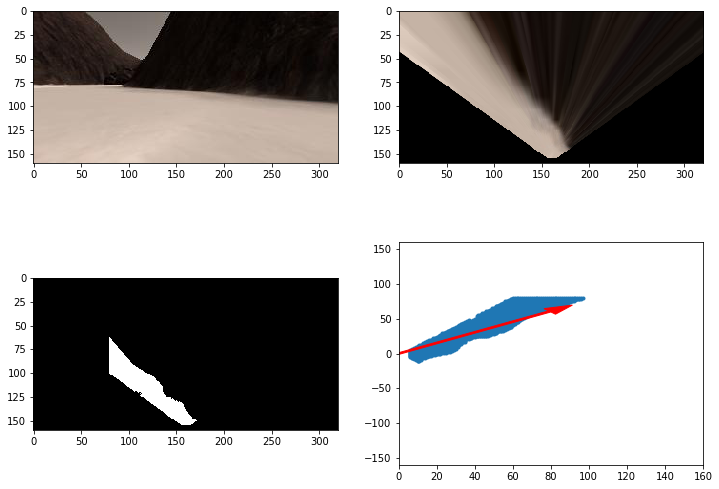

In [9]:
def rover_coords(binary_img):
    """Converts from image coordinates to rover coordinates.
    Accepts the binary image returned from color_thresh().
    Returns [x, y] coordinates with an origin at the Rover's camera."""

    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()

    # Calculate pixel positions with reference to the rover position
    # being at the center bottom of the image.
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1] / 2).astype(np.float)

    return x_pixel, y_pixel


def to_polar_coords(x_pixel, y_pixel):
    """Convert the [x_pixel, y_pixel] from rover_coords() to [distance, angle].
    Where each pixel position is represented by its distance from the origin
    and counterclockwise angle from the positive x-direction."""

    # Calculate distance from Rover to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)

    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    
    return dist, angles


def rotate_pix(xpix, ypix, yaw):
    """Maps rover space pixels to world space.
    Used for turning the Rover."""

    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180

    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))

    return xpix_rotated, ypix_rotated


def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale):
    """Translate rover-centric coordinates back into world coordinates."""

    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos

    return xpix_translated, ypix_translated


def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    """Performs the rotation and translation actions required
    for Rover movement & mapping the environment."""

    # Apply rotation using the rotate_pix() function
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)

    # Apply translation using the translate_pix() function
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)

    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)

    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped, mask = perspective_transform(image, source, destination)
threshed = color_thresh(warped) * mask

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Detect Rocks Function:

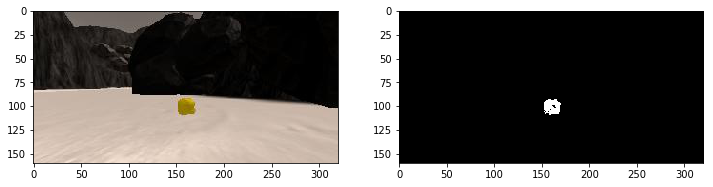

In [10]:
def find_rocks(img, levels=(110, 110, 50)):
    """Find rocks by applying a RGB threshold to detect rock samples within
    the input threshold. Very similar to the color_thresh() function."""

    # The rocks have high Red and Green levels & low Blue levels
    rockpix = ((img[:, :, 0] > levels[0])
               & (img[:, :, 1] > levels[1])
               & (img[:, :, 2] < levels[2]))
    
    color_select = np.zeros_like(img[:, :, 0])
    color_select[rockpix] = 1

    return color_select

rock_map = find_rocks(rock_img)
fig = plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.imshow(rock_img)
plt.subplot(122)
plt.imshow(rock_map, cmap='gray')

## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  

---

**Notes:**

* ``robot_log.cvs`` contains the values from the rover's sensors 
* ``map_bw.png`` is a map of navigable terrain
    - Saved as a dataframe of 1's and 0's

In [11]:
# Import pandas and read in csv file as a dataframe
import pandas as pd

# Change the path below to your data directory
# Save the values from the rover's sensors to a pandas dataframe
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')

# Create list of image pathnames
# Used later to make a movie of the rover's run
csv_img_list = df["Path"].tolist() 

# Read in ground truth map and create a 3-channel image with it
# Navigable values are 1
# Other values are 0
ground_truth = mpimg.imread('../calibration_images/map_bw.png')

# Give the navigable terrain a green color instead of white
#      by multipling Navigable [1] values by [255] 
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## The Perception Step

In [13]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    # 4) Convert thresholded image pixel values to rover-centric coords
    # 5) Convert rover-centric pixel values to world coords
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1

        
    # Perspective Transfrom and Mask
    warped, mask = perspect_transform(img, source, destination)
    # Apply color threshold to identify navigable terrain/obstacles/rocksamples
    # Map of navigable pixels 
    threshed = color_thresh(warped)
    # Apply the mask on the threshed map
    obs_map = np.absolute(np.float32(threshed) - 1) * mask
    
    # Convert to rover coordinates
    xpix, ypix = rover_coords(threshed)
    
    # 6) Convert rover-centric pixal values to world coordinates 
    world_size = data.worldmap.shape[0]
    scale = 2 * dst_size
    xpos = data.xpos[data.count]
    ypos = data.ypos[data.count]
    yaw = data.yaw[data.count]
    x_world, y_world = pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale)
    
    obsxpix, obsypix = rover_coords(obs_map)
    obs_x_world, obs_y_world = pix_to_world(obsxpix, obsypix, xpos, ypos, yaw, world_size, scale)
    
    # 7) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    
    # World Map's Blue Channel
    data.worldmap[y_world, x_world, 2] = 255
    # World Map's Red Channel
    data.worldmap[obs_y_world, obs_x_world, 0] = 255
    
    # To prevent overlap:
    # Setting the red channel to 0 if 
    # to the blue channel is > 0
    nav_pix = data.worldmap[:,:,2] > 0
    data.worldmap[nav_pix, 0] = 0
    
    
    # Find Rocks
    rock_map = find_rocks(warped, levels=(110, 110, 50))
    if rock_map.any():
        rock_x, rock_y = rover_coords(rock_map)
        rock_x_world, rock_y_world = pix_to_world(rock_x, rock_y, xpos, ypos, yaw, world_size, scale)
        
        data.worldmap[rock_y_world, rock_x_world, :] = 255
    
    # Output Results:
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
    # Next you can populate regions of the image with various output
    output_image[0:img.shape[0], 0:img.shape[1]] = img

    # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

    # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
    # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


    # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

### Note:
- Test output video was screen recorded so the console could be apart of the video.
- The video is named: **Test-Run-Video**